# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [5]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia langchain_tavily langchain_groq

## **Setup**

In [1]:
import os, operator, warnings, getpass
from typing import List, TypedDict, Annotated
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langchain_tavily import TavilySearch
from langchain_community.document_loaders import WikipediaLoader
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Send
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, BaseMessage
from langchain_core.messages import get_buffer_string
from IPython.display import Image, display, Markdown
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from prompt import *

warnings.filterwarnings("ignore")

/home/muhammadumerkhan/Gen-Agentic-AI-Tutorials/.venv/lib/python3.12/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
/home/muhammadumerkhan/Gen-Agentic-AI-Tutorials/.venv/lib/python3.12/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


In [2]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("LANGSMITH_API_KEY")

In [3]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm.invoke("Hello, how are you?").content

"Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?"

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = "research_assistant"

## **Generate Analysts: Human-In-The-Loop**

Create analysts and review them using human-in-the-loop.

In [5]:
class Analysts(BaseModel):
    affiliation: str = Field(..., description="Primary affiliation of the analyst.")
    name: str = Field(..., description="Name of the analyst.")
    role: str = Field(..., description="Role of the analyst in the context of topic.")
    description: str = Field(..., description="Description of the analyst focus, concerns, and motives.")

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analyst: List[Analysts] = Field(
        description="comprehensive list of analysts with their roles, descriptions, and affiliations."
        )

In [6]:
class GenerateAnalystState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analysts]

In [7]:
def create_analyst(state: GenerateAnalystState) -> dict:
    """Create an analyst to generate a report."""
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    # Create a structured LLM
    structured_llm = llm.with_structured_output(Perspectives)
    
    # system prompt
    system_prompt = SystemMessage(
        content=ANALYST_INSTRUCTIONS.format(
            topic=topic,
            max_analysts=max_analysts,
            human_analyst_feedback=human_analyst_feedback,
        ))
    
    # human message
    human_message = HumanMessage(content="Create a set of analysts.")

    # create the analyst
    analysts = structured_llm.invoke([system_prompt, human_message])

    return {"analysts": analysts.analyst }

In [8]:
analysts = create_analyst({
    "topic": "AI Agents",
    "max_analysts": 2,
})

In [9]:
for analyst in analysts.get("analysts"):
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 100)

Name: Dr. Emily Carter
Affiliation: Tech Innovations Lab
Role: AI Ethics Analyst
Description: Dr. Carter focuses on the ethical implications of AI agents, exploring issues such as bias, accountability, and the societal impact of deploying AI technologies. Her work aims to ensure that AI systems are developed and used responsibly, promoting fairness and transparency.
----------------------------------------------------------------------------------------------------
Name: Mr. James Liu
Affiliation: Future of Work Institute
Role: AI Integration Specialist
Description: Mr. Liu specializes in the integration of AI agents into various industries, analyzing how these technologies can enhance productivity and efficiency. He is particularly interested in the future of work and how AI can reshape job roles and workforce dynamics.
----------------------------------------------------------------------------------------------------


In [10]:
def human_feedback(state: GenerateAnalystState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystState):
    """ Return the next node to execute """
    
    # Check if human feedback is present
    if state.get("human_analyst_feedback", None):
        return "create_analyst"
    return END

In [11]:
# Add nodes and edges 
analyst_builder = StateGraph(GenerateAnalystState)

# Add nodes
analyst_builder.add_node("create_analyst", create_analyst)
analyst_builder.add_node("human_feedback", human_feedback)

# Add edges
analyst_builder.add_edge(START, "create_analyst")
analyst_builder.add_edge("create_analyst", "human_feedback")
analyst_builder.add_conditional_edges("human_feedback", should_continue, ["create_analyst", END])

# Compile graph
memory = MemorySaver()
analyst_graph = analyst_builder.compile(checkpointer=memory, interrupt_before=["human_feedback"])

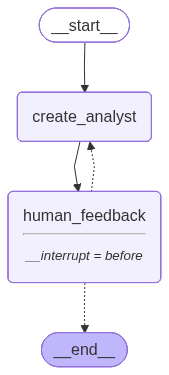

In [12]:
# View
display(Image(analyst_graph.get_graph(xray=1).draw_mermaid_png()))
# analyst_graph

### **Test the Graph**

In [13]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

input_state = { "topic": topic, "max_analysts": max_analysts }

# Run the graph until the first interruption
for event in analyst_graph.stream(input_state, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 100)

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of LangGraph, analyzing its architecture and performance metrics compared to other frameworks. She is particularly interested in how LangGraph can enhance the efficiency of AI agents in real-world applications.
----------------------------------------------------------------------------------------------------
Name: Mr. James Liu
Affiliation: Future of Work Institute
Role: Workplace Integration Analyst
Description: Mr. Liu examines the implications of adopting LangGraph in organizational settings. His research emphasizes the impact on team dynamics, productivity, and the overall workflow when integrating AI agents powered by LangGraph.
----------------------------------------------------------------------------------------------------
Name: Dr. Sarah Thompson
Affiliation: AI Ethics Council
Role: Ethics and Compliance Advisor
Description: Dr

In [14]:
# Get state and look at next node
current_state = analyst_graph.get_state(thread)
current_state.next

('human_feedback',)

In [15]:
# Continue the graph execution to end
for event in analyst_graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
human_feedback


In [16]:
# If we are satisfied, then we simply supply no feedback
further_feedback = None
analyst_graph.update_state(
    thread, 
    { "human_analyst_feedback": further_feedback}, as_node="human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e873b-fe1c-681d-8003-658daa1f69b1'}}

In [17]:
# Continue the graph execution to end
for event in analyst_graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [18]:
final_state = analyst_graph.get_state(thread)
analysts = final_state.values.get("analysts")

In [19]:
final_state.next

()

In [20]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of LangGraph, analyzing its architecture and performance metrics compared to other frameworks. She is particularly interested in how LangGraph can enhance the efficiency of AI agents in real-world applications.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future of Work Institute
Role: Workplace Integration Analyst
Description: Mr. Liu examines the implications of adopting LangGraph in organizational settings. His research emphasizes the impact on team dynamics, productivity, and the overall workflow when integrating AI agents powered by LangGraph.
--------------------------------------------------
Name: Dr. Sarah Thompson
Affiliation: AI Ethics Council
Role: Ethics and Compliance Advisor
Description: Dr. Thompson investigates the ethical considerations surrounding the use of LangGraph as an agent fram

## **Conduct Interview**

### **Generate Question**

- **The analyst will ask questions to the expert.**

In [ ]:
class InterviewState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]    # Messages
    max_num_turns: int                                      # Number turns of conversation
    context: Annotated[list, add_messages]                  # Source docs
    analyst: Analysts                                       # Analyst asking questions
    interview: str                                          # Interview transcript
    sections: str                                           # Final key we duplicate in outer state for Send() API

    # search_query: Annotated[List, add_messages]

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [69]:
def generate_question(state: InterviewState) -> dict:
    """ Generate question for analyst. """
    
    analyst = state['analyst']
    messages = state['messages']

    # generate question
    system_message = SystemMessage(content=QUESTION_INSTRUCTIONS.format(goals=analyst.persona))
    question = llm.invoke([system_message] + messages)

    # write message to state
    return { "messages": [question] }

In [26]:
# in above node change "analyst.persona -> analyst['persona']" for testing below analyst persona
analyst_persona = {
    "persona":
    f"Name: {analyst.name}, \nRole: {analyst.role}, \nDescription: {analyst.description} \nAffiliation: {analyst.affiliation}"
    }
analyst_persona['persona']

'Name: Dr. Sarah Thompson, \nRole: Ethics and Compliance Advisor, \nDescription: Dr. Thompson investigates the ethical considerations surrounding the use of LangGraph as an agent framework. She is concerned with issues of transparency, accountability, and the potential biases that may arise from AI systems utilizing this framework. \nAffiliation: AI Ethics Council'

In [27]:
question = generate_question({
    "analyst": analyst_persona,
    "messages": [],
})

In [29]:
question['messages'][0].content

'Hello, Dr. Thompson. My name is Alex Carter, and I’m an analyst focused on the ethical implications of AI technologies. I appreciate you taking the time to speak with me today. \n\nTo start, could you share some specific ethical concerns you have regarding the use of LangGraph as an agent framework? What are some surprising aspects of these concerns that you’ve encountered in your work?'

## **Generate Answer: Parallelization**
The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

- Specific web sites e.g., via WebBaseLoader
- Indexed documents e.g., via [RAG](https://docs.langchain.com/oss/python/langchain/retrieval)
- Web search
- Wikipedia search

You can try different web search tools, like [Tavily](https://www.tavily.com/).

In [70]:
tavily_search = TavilySearch(max_results=3)

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

In [72]:
def web_search(state: InterviewState) -> dict:
    """ Retrieve docs from web search """
    
    message = state['messages']
    
    # search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke(
        [SEARCH_INSTRUCTIONS] + message
    )

    # search
    data = tavily_search.invoke({"query": search_query.search_query})
    search_docs = data.get("results", data)

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    # Write to state
    return { "context": [formatted_search_docs]}

In [32]:
web_search_result = web_search({"messages": question["messages"]})

In [33]:
Markdown(web_search_result['search_query'][0].search_query)

ethical concerns regarding LangGraph agent framework AI technologies

In [34]:
Markdown(web_search_result['context'][0])

<Document href="https://link.springer.com/10.1007/978-981-95-2909-4_17"/>
# Ethical Considerations in AI Agents. This chapter examines the ethical dimensions of AI agents, with particular focus on autonomous systems capable of independent decision-making in real-world environments. The chapter distinguishes between standard AI agents and autonomous systems, exploring their components including perception, decision-making, and action mechanisms. The chapter also covers practical frameworks for implementing AI agents using modern tools like LangChain, LangGraph, and Hugging Face, while emphasizing the importance of ethical design principles. Patiency is not a virtue: AI and the design of ethical systems. *Ethics and Information Technology,* *20*(1), 15–26. *Nature Machine Intelligence,* *1*(9), 389–399. *Nature Machine Intelligence,* *1*(11), 501–507. Machine ethics: The design and governance of ethical AI and autonomous systems. The global landscape of AI ethics guidelines*.* *Nature Machine Intelligence*. *Nature Machine Intelligence,* *1*(5), 206–215. What is reproducibility in artificial intelligence and machine learning research? *Machine learning and artificial intelligence research for patient benefit: 20 critical questions on transparency, replicability, ethics, and effectiveness*. Ethical Considerations in AI Agents.
</Document>

---

<Document href="https://www.researchgate.net/publication/397657433_Ethical_Considerations_in_AI_Agents"/>
This chapter examines the ethical dimensions of AI agents, with particular focus on autonomous systems capable of independent
</Document>

---

<Document href="https://medium.com/@sparkoutdigitalmarketing/ethical-considerations-in-ai-agent-development-ensuring-responsible-ai-74f637ceff9b"/>
AI agents process massive amounts of user data, raising concerns about data privacy, misuse, and security breaches. Personal information can be
</Document>

In [73]:
def search_wikipedia(state: InterviewState) -> dict:
    """ Retrieve docs from web search """
    
    message = state['messages']
    
    # search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke(
        [SEARCH_INSTRUCTIONS] + message
    )

    # search
    search_docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    # Write to state
    return { "context": [formatted_search_docs]}

In [36]:
search_wikipedia_result = search_wikipedia({
    "messages": question["messages"]
})

In [37]:
Markdown(search_wikipedia_result['search_query'][0].search_query)

ethical concerns of LangGraph agent framework AI technologies

In [38]:
Markdown(search_wikipedia_result['context'][0])

<Document source="https://en.wikipedia.org/wiki/Applications_of_artificial_intelligence" page=""/>
Artificial intelligence is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. Artificial intelligence has been used in applications throughout industry and academia. Within the field of Artificial Intelligence, there are multiple subfields. The subfield of Machine learning has been used for various scientific and commercial purposes including language translation, image recognition, decision-making, credit scoring, and e-commerce. In recent years, there have been massive advancements in the field of generative artificial intelligence, which uses generative models to produce text, images, videos or other forms of data. This article describes applications of AI in different sectors.


== Agriculture ==

In agriculture, AI has been proposed as a way for farmers to identify areas that need irrigation, fertilization, or pesticide treatments to increase yields, thereby improving efficiency. AI has been used to attempt to classify livestock pig call emotions, automate greenhouses, detect diseases and pests, and optimize irrigation.


== Architecture and design ==


== Business ==

A 2023 study found that generative AI increased productivity by 15% in contact centers. Another 2023 study found it increased productivity by up to 40% in writing tasks. An August 2025 review by MIT found that of surveyed companies, 95% did not report any improvement in revenue from the use of AI. A September 2025 article by the Harvard Business Review describes how increased use of AI does not automatically lead to increases in revenue or actual productivity. Referring to "AI generated work content that masquerades as good work, but lacks the substance to meaningfully advance a given task" the article coins the term workslop. Per studies done in collaboration with the Stanford Social Media Lab, workslop does not improve productivity and undermines trust and collaboration among colleagues.


== Computer science ==


=== Programming assistance ===


==== AI-assisted software development ====
AI can be used for real-time code completion, chat, and automated test generation. These tools are typically integrated with editors and IDEs as plugins. AI-assisted software development systems differ in functionality, quality, speed, and approach to privacy. Creating software primarily via AI is known as "vibe coding". Code created or suggested by AI can be incorrect or inefficient. The use of AI-assisted coding can potentially speed-up software development, but can also slow-down the process by creating more work when debugging and testing. The rush to prematurely adopt AI technology can also incur additional technical debt. AI also requires additional consideration and careful review for cybersecurity, since AI coding software is trained on a wide range of code of inconsistent quality and often replicates poor practices.


==== Neural network design ====

AI can be used to create other AIs. For example, around November 2017, Google's AutoML project to evolve new neural net topologies created NASNet, a system optimized for ImageNet and POCO F1. NASNet's performance exceeded all previously published performance on ImageNet.


==== Quantum computing ====

Research and development of quantum computers has been performed with machine learning algorithms. For example, there is a prototype, photonic, quantum memristive device for neuromorphic computers (NC)/artificial neural networks and NC-using quantum materials with some variety of potential neuromorphic computing-related applications. The use of quantum machine learning  for quantum simulators has been proposed for solving physics and chemistry problems.


=== Historical contributions ===
AI researchers have created many tools to solve the most difficult problems in computer science. Many of their inventions have been adopted by mainstream computer science and are no longer considered AI. Al
</Document>

---

<Document source="https://en.wikipedia.org/wiki/Timeline_of_computing_2020%E2%80%93present" page=""/>
This article presents a detailed timeline of events in the history of computing from 2020 to the present. For narratives explaining the overall developments, see the history of computing.
Significant events in computing include events relating directly or indirectly to software, hardware and wetware.
Excluded (except in instances of significant functional overlap) are:

events in general robotics
events about uses of computational tools in biotechnology and similar fields (except for improvements to the underlying computational tools) as well as events in media-psychology except when those are directly linked to computational tools
Currently excluded are:

events in computer insecurity/hacking incidents/breaches/Internet conflicts/malware if they are not also about milestones towards computer security
events about quantum computing and communication
economic events and events of new technology policy beyond standardization


== 2025 ==


=== AI ===
On January 14, the New York Times, The New York Daily News, and the Center of Investigative Reporting have a hearing in a combined lawsuit against OpenAI.
OpenAI develops a model called "GPT 4b-micro", which suggests ways that protein factors could be re-engineered to become more effective.
DeepSeek releases DeepSeek-R1 on 20 January, a large language model based on DeepSeek-V3 utilising a chain-of-thought process similar to OpenAI o1.
On May 18, 2025, 15 launches 15.dev as the successor to 15.ai.
The race for the most advanced AI continues, with new models like OpenAI GPT-5.1 release and reports of SoftBank selling its Nvidia stake to double down on Open AI bets.


== 2024 ==


=== AI ===
An AI-based study shows for the first time that fingerprints from different fingers of the same person share strong detectable similarities.
A preprint trial suggests large language models could be used for tailored manipulation, being more persuasive than humans when using personal information.
Notable innovations: LAION releases a first version of BUD-E, a fully open source voice assistant, an automatic waste sorting system that can distinguish between over 500 waste categories is released, researchers describe an AI ecosystem interface of foundation models connected to many APIs as specialized subtask-solvers, the chatbot Grok is made open source to a substantial extent.
John Hopfield and Geoffrey Hinton win the Nobel Prize in Physics "for foundational discoveries and inventions that enable machine learning with artificial neural networks"


=== Hardware ===
Researchers describe an approach for an optical disk with petabit capacity,


=== Internet penetration ===
According to the International Telecommunication Union, the global Internet population reached 5.5 billion in 2024, meaning more than two-thirds of the world's population is now online.


== 2023 ==


=== AI ===

Chatbot and text-generating AI, ChatGPT (released on 30 Nov 2022), a large language model, became popular, with some considering the large public's attention as unwarranted hype as potential applications are limited. Similar software such as Cleverbot existed for many years, and the software is, on the fundamental level, not structured toward accuracy – e.g. providing seemingly credible but incorrect answers to queries and operating "without a contextual understanding of the language" – but only toward essentially the authenticity of mimicked human language. It was estimated that only two months after its launch, it had 100 million active users. Applications may include solving or supporting school writing assignments, malicious social bots (e.g. for misinformation, propaganda, and scams), and providing inspiration (e.g. for artistic writing or in design or ideation in general).
Google released chatbot Bard due to effects of the ChatGPT release, with potential for integration into its Web search and, like ChatGPT software, also as a software development helper tool. DuckDuckGo released the DuckAssist feature integrated into it
</Document>

In [74]:
def generate_answer(state: InterviewState) -> dict:
    """ Generate answer for analyst. """
    
    analyst = state['analyst']
    messages = state['messages']
    context = state['context']

    # generate question
    system_message = SystemMessage(content=ANSWER_INSTRUCTIONS.format(goals=analyst.persona, context=context))
    answer = llm.invoke([system_message] + messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # write message to state
    return { "messages": [answer] }

In [40]:
answer = generate_answer({
    "analyst": analyst_persona,
    "messages": question["messages"],
    "context": web_search_result["context"][0]
})

In [50]:
answer["messages"][0].name

'expert'

In [51]:
Markdown(answer['messages'][0].content)

Thank you for the opportunity to discuss these important issues. One of the primary ethical concerns surrounding the use of LangGraph as an agent framework is the potential for biases that may arise from the data used to train these AI systems. Since AI agents process vast amounts of user data, there is a significant risk of perpetuating existing biases or introducing new ones, which can lead to unfair or discriminatory outcomes in decision-making processes.

Additionally, transparency is a critical issue. Users and stakeholders need to understand how these AI agents make decisions, which requires clear communication about the underlying algorithms and data sources. Without transparency, it becomes challenging to hold these systems accountable for their actions, raising questions about responsibility when an AI agent makes a harmful decision.

Another surprising aspect is the ethical design principles that are often overlooked in the development of AI agents. Many developers may prioritize functionality and performance over ethical considerations, which can lead to systems that are not only ineffective but also potentially harmful. This highlights the need for a framework that integrates ethical considerations into the design and implementation of AI agents from the outset.

In summary, the key ethical concerns include bias, transparency, accountability, and the integration of ethical design principles in the development of AI agents like those utilizing LangGraph [1][2][3]. 

Sources:
[1] https://link.springer.com/10.1007/978-981-95-2909-4_17
[2] https://www.researchgate.net/publication/397657433_Ethical_Considerations_in_AI_Agents
[3] https://medium.com/@sparkoutdigitalmarketing/ethical-considerations-in-ai-agent-development-ensuring-responsible-ai-74f637ceff9b

In [75]:
def save_interview(state: InterviewState) -> dict:
    """ Save interview transcript to state """
    
    # Get messages
    messages = state['messages']
    
    # Convert interview transcript to string
    interview = get_buffer_string(messages)

    # Save the interview key to state
    return { "interview": interview }

In [53]:
interview = save_interview({
    "messages": question["messages"]
})
Markdown(interview['interview'])

AI: Hello, Dr. Thompson. My name is Alex Carter, and I’m an analyst focused on the ethical implications of AI technologies. I appreciate you taking the time to speak with me today. 

To start, could you share some specific ethical concerns you have regarding the use of LangGraph as an agent framework? What are some surprising aspects of these concerns that you’ve encountered in your work?

In [54]:
[m for m in question['messages'] if isinstance(m, AIMessage)]

[AIMessage(content='Hello, Dr. Thompson. My name is Alex Carter, and I’m an analyst focused on the ethical implications of AI technologies. I appreciate you taking the time to speak with me today. \n\nTo start, could you share some specific ethical concerns you have regarding the use of LangGraph as an agent framework? What are some surprising aspects of these concerns that you’ve encountered in your work?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 237, 'total_tokens': 315, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_c4585b5b9c', 'id': 'chatcmpl-Ctq8BmImM7A1apOas9Pl9B6UwIiXl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b

In [76]:
def route_messages(state: InterviewState, name: str = "expert") -> dict:
    """ Route between question and answer """

    # Get messages
    messages = state['messages']
    max_num_turns = state.get('max_num_turns', 2)
    
    # Check the number of expert answers 
    num_responses = len(
        [
            m for m in messages if isinstance(m, AIMessage) and m.name == name
        ]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "save_interview"
    
    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_message = messages[-2]

    if "Thank you so much for your help" in last_message.content:
        return 'save_interview'
    return "ask_question"

In [82]:
def write_section(state: InterviewState):
    """ Node to answer a question """

    # Get state
    interview = state['interview']
    context = state['context']
    analyst = state['analyst']

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_prompt = SystemMessage(content=SECTION_WRITER_INSTRUCTIONS.format(
        focus=analyst.description
    ))
    human_message = HumanMessage(content=f"Use this source to write your section: {context}")
    sections = llm.invoke(
        [system_prompt] + [human_message]
    )

    # Write to state
    return { "sections": [sections.content] }

In [59]:
section = write_section({
    "interview": interview['interview'],
    "context": search_wikipedia_result['context'][0],
    "analyst": analyst.description
})

In [61]:
Markdown(section['sections'])

## Ethical Considerations in the Use of LangGraph as an AI Framework

### Summary
Artificial intelligence (AI) has rapidly evolved, becoming integral to various sectors, including agriculture, business, and computer science. As AI systems, such as LangGraph, gain traction, ethical considerations surrounding their use become increasingly critical. Dr. Thompson's investigation highlights the importance of transparency, accountability, and the potential biases inherent in AI frameworks. Notably, while generative AI has shown promise in enhancing productivity—evidenced by a 15% increase in contact centers and up to 40% in writing tasks—concerns arise regarding the quality of AI-generated content. A term coined "workslop" describes AI-generated work that lacks substance, potentially undermining trust and collaboration among users [1].

The advancements in AI, particularly in machine learning and generative models, have led to significant applications across industries. For instance, AI is being utilized in agriculture to optimize irrigation and detect diseases, while in business, it has been linked to increased productivity. However, the findings from recent studies indicate that a majority of companies have not experienced revenue growth from AI adoption, raising questions about the effectiveness of these technologies [1][2]. 

Moreover, the rapid integration of AI in software development, such as real-time code completion and automated testing, presents both opportunities and challenges. While these tools can accelerate development, they may also introduce inefficiencies and technical debt, necessitating careful consideration of their implementation [1]. The ethical implications of AI-assisted coding, including the potential replication of poor practices, further complicate the landscape.

As AI continues to evolve, the need for frameworks that prioritize ethical considerations becomes paramount. The potential for biases in AI systems, particularly those utilizing frameworks like LangGraph, necessitates ongoing scrutiny to ensure that these technologies serve to enhance human capabilities rather than diminish them. The insights gathered from this investigation underscore the importance of fostering a responsible AI ecosystem that emphasizes ethical practices and accountability.

### Sources
[1] https://en.wikipedia.org/wiki/Applications_of_artificial_intelligence  
[2] https://en.wikipedia.org/wiki/Timeline_of_computing_2020%E2%80%93present  

In [83]:
# define graph
interview_builder = StateGraph(InterviewState)

# add graph nodes
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("web_search", web_search)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("generate_answer", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# add graph edges
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "web_search")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("web_search", "generate_answer")
interview_builder.add_edge("search_wikipedia", "generate_answer")

interview_builder.add_conditional_edges(
    "generate_answer", route_messages, ["ask_question", "save_interview"]
)

interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Checpointer
memory = MemorySaver()

# compile graph
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interview")

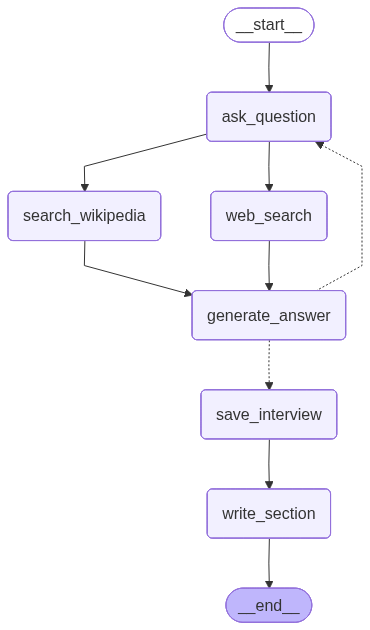

In [84]:
# View
# display(Image(interview_graph.get_graph(xray=1).draw_mermaid_png()))
interview_graph

In [85]:
analysts[0]

Analysts(affiliation='Tech Innovations Inc.', name='Dr. Emily Carter', role='AI Framework Specialist', description='Dr. Carter focuses on the technical advantages of LangGraph, analyzing its architecture and performance metrics compared to other frameworks. She is particularly interested in how LangGraph can enhance the efficiency of AI agents in real-world applications.')

In [86]:
topic = "The benefits of adopting LangGraph as an agent framework"
messages = [HumanMessage(content=f"So you said you were writing an article on {topic}?")]

thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)

In [89]:
interview.keys()

dict_keys(['messages', 'max_num_turns', 'context', 'analyst', 'interview'])

In [87]:
Markdown(interview['sections'][0])

KeyError: 'sections'